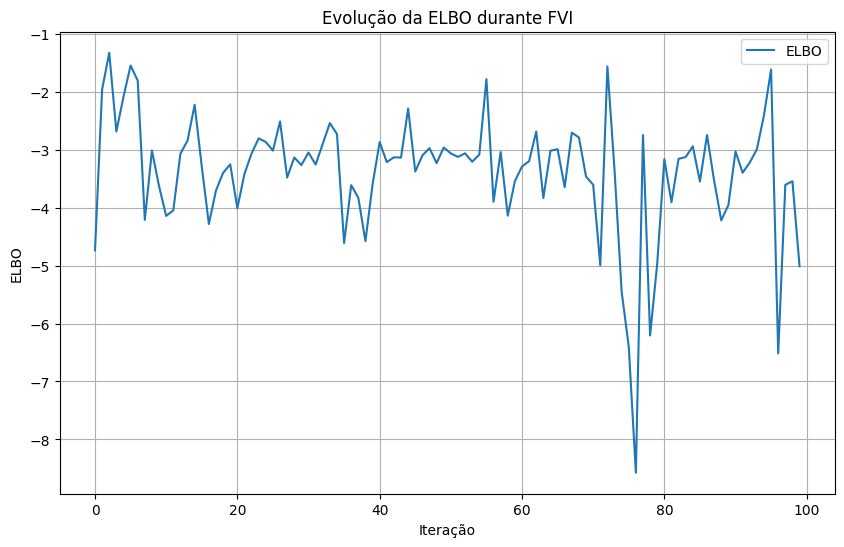

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Dado observado fixo
x_obs = 1.5

# Inicialização dos parâmetros variacionais
mu = 0.0              # média inicial da distribuição q(z)
log_sigma = 0.0       # usamos log_sigma para garantir que sigma > 0

# Função para calcular o log de uma normal N(x | mean, std)
def log_normal(x, mean, std):
    return -0.5 * np.log(2 * np.pi) - np.log(std) - 0.5 * ((x - mean) / std) ** 2

# Lista para salvar a ELBO a cada iteração
elbo_history = []

# Taxa de aprendizado
lr = 0.1

# Loop de otimização do FVI
for step in range(100):  # 100 iterações
    sigma = np.exp(log_sigma)             # transforma log_sigma em sigma > 0
    epsilon = np.random.randn()           # amostra da normal padrão
    z = mu + sigma * epsilon              # reparametrização: z ~ q(z)

    # Cálculo da ELBO: log p(z) + log p(x|z) - log q(z)
    log_pz = log_normal(z, 0, 1)                  # log do prior
    log_px_given_z = log_normal(x_obs, z, 1)      # log da verossimilhança
    log_qz = log_normal(z, mu, sigma)             # log da aproximação q(z)

    elbo = log_pz + log_px_given_z - log_qz
    elbo_history.append(elbo)

    # Gradientes analíticos (derivadas manuais)

    # Derivada do log q(z) em relação a mu e log_sigma
    dlog_qz_dmu = (z - mu) / (sigma ** 2)
    dlog_qz_dlog_sigma = ((z - mu) ** 2 - sigma ** 2) / (sigma ** 2)

    # Derivadas do log p(x|z) e log p(z) em relação a z
    dlog_px_given_z_dz = (x_obs - z)
    dlog_pz_dz = -z

    # Reparametrização: como z depende de mu e log_sigma
    dz_dmu = 1
    dz_dlog_sigma = sigma * epsilon

    # Gradiente total da ELBO com relação a mu
    delbo_dmu = (dlog_px_given_z_dz + dlog_pz_dz - dlog_qz_dmu) * dz_dmu

    # Gradiente total da ELBO com relação a log_sigma
    delbo_dlog_sigma = (-dlog_qz_dlog_sigma) * dz_dlog_sigma

    # Atualização dos parâmetros via gradiente ascendete (maximização da ELBO)
    mu += lr * delbo_dmu
    log_sigma += lr * delbo_dlog_sigma

# Plot da evolução da ELBO durante as iterações
plt.figure(figsize=(10, 6))
plt.plot(elbo_history, label='ELBO')
plt.title("Evolução da ELBO durante FVI")
plt.xlabel("Iteração")
plt.ylabel("ELBO")
plt.legend()
plt.grid(True)
plt.show()


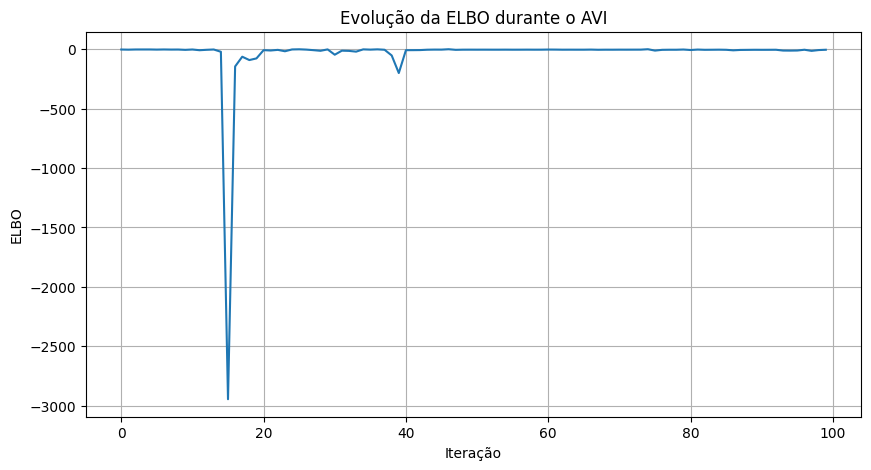

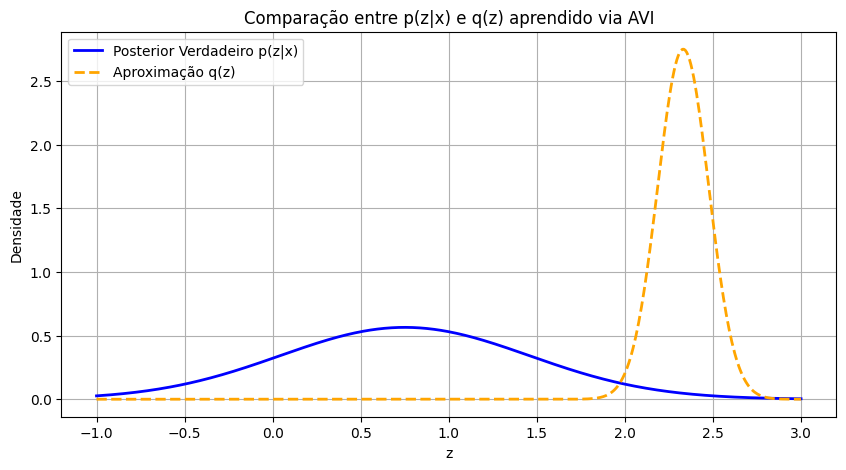

Posterior verdadeiro: N(0.750, 0.500)
Aproximação q(z):     N(2.331, 0.021)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ---------------------------
# 1. Dado observado fixo
# ---------------------------
x_obs = 1.5

# ---------------------------
# 2. Inicialização dos parâmetros variacionais
# ---------------------------
mu = 0.0              # média inicial de q(z)
log_sigma = 0.0       # log da variância (para garantir sigma > 0)

# ---------------------------
# 3. Função log-probabilidade da normal
# ---------------------------
def log_normal(x, mean, std):
    return -0.5 * np.log(2 * np.pi) - np.log(std) - 0.5 * ((x - mean) / std) ** 2

# ---------------------------
# 4. Parâmetros de otimização
# ---------------------------
elbo_history = []
lr = 0.1
n_steps = 100


# ---------------------------
# 5. Loop de otimização (AVI)
# ---------------------------
for step in range(n_steps):
    sigma = np.exp(log_sigma)
    epsilon = np.random.randn()  # Amostragem da normal padrão
    z = mu + sigma * epsilon     # Reparametrização: z ~ q(z)

    # ELBO = log p(z) + log p(x|z) - log q(z)
    log_pz = log_normal(z, 0, 1)
    log_px_given_z = log_normal(x_obs, z, 1)
    log_qz = log_normal(z, mu, sigma)

    elbo = log_pz + log_px_given_z - log_qz
    elbo_history.append(elbo)

    # Gradientes manuais
    dlog_qz_dmu = (z - mu) / (sigma ** 2)
    dlog_qz_dlog_sigma = ((z - mu) ** 2 - sigma ** 2) / (sigma ** 2)
    dlog_px_given_z_dz = (x_obs - z)
    dlog_pz_dz = -z

    dz_dmu = 1
    dz_dlog_sigma = sigma * epsilon

    delbo_dmu = (dlog_px_given_z_dz + dlog_pz_dz - dlog_qz_dmu) * dz_dmu
    delbo_dlog_sigma = (-dlog_qz_dlog_sigma) * dz_dlog_sigma

    # Atualização dos parâmetros
    mu += lr * delbo_dmu
    log_sigma += lr * delbo_dlog_sigma

# ---------------------------
# 6. Plot da ELBO ao longo das iterações
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(elbo_history)
plt.title("Evolução da ELBO durante o AVI")
plt.xlabel("Iteração")
plt.ylabel("ELBO")
plt.grid(True)
plt.show()

# ---------------------------
# 7. Comparação com o Posterior Verdadeiro
# ---------------------------
# Prior: p(z) = N(0,1)
# Likelihood: p(x | z) = N(z, 1)
# Posterior exato: p(z|x) = N(mu_post, var_post)

var_post = 1 / (1 + 1)           # var = 1 / (1/σ_p^2 + 1/σ_l^2)
mu_post = var_post * x_obs       # = (1/2) * 1.5 = 0.75
std_post = np.sqrt(var_post)

# Aproximação q(z)
sigma = np.exp(log_sigma)

# Grid de valores z
z_values = np.linspace(-1, 3, 500)
posterior = norm.pdf(z_values, mu_post, std_post)
q_approx = norm.pdf(z_values, mu, sigma)

# ---------------------------
# 8. Plot: Comparação entre p(z|x) e q(z)
# ---------------------------
plt.figure(figsize=(10, 5))
plt.plot(z_values, posterior, label='Posterior Verdadeiro p(z|x)', color='blue', linewidth=2)
plt.plot(z_values, q_approx, label='Aproximação q(z)', color='orange', linestyle='--', linewidth=2)
plt.title("Comparação entre p(z|x) e q(z) aprendido via AVI")
plt.xlabel("z")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# 9. Resultado final
# ---------------------------
print(f"Posterior verdadeiro: N({mu_post:.3f}, {var_post:.3f})")
print(f"Aproximação q(z):     N({mu:.3f}, {sigma**2:.3f})")
